In [6]:
import os
import matplotlib

from utils import *
from slam import *
from load_data import *

%matplotlib inline

### Load Test Data

In [26]:
TEST_DIR = 'test_data/'
TEST_NO = '22'

### Data Preprocessing

In [27]:
%%time

encoders = get_encoder(os.path.join(TEST_DIR, 'Encoders' + TEST_NO))
hokuyo = get_lidar(os.path.join(TEST_DIR, 'Hokuyo' + TEST_NO))
imu = get_imu(os.path.join(TEST_DIR, 'imu' + TEST_NO))

sample_rate = 10
offset = getStaticOffset(encoders)
xs, ys, thetas, timestamps = getOdometry(encoders, sample_rate, offset)
lidars = getMatchedLidarData(hokuyo, timestamps)
imus = getMatchedImuData(imu, timestamps)
gyro_y = imus[:, 4]
tilted = isTilted(gyro_y)

CPU times: user 276 ms, sys: 118 ms, total: 394 ms
Wall time: 394 ms


### Run SLAM

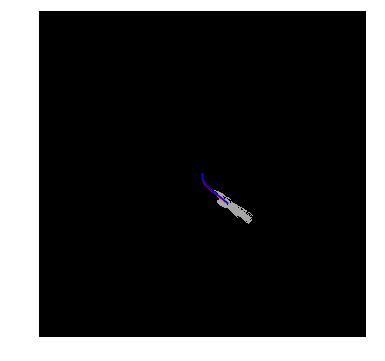

figure 51 is saved to results/22_10_200_15.0_-15.0_0.3_51.png


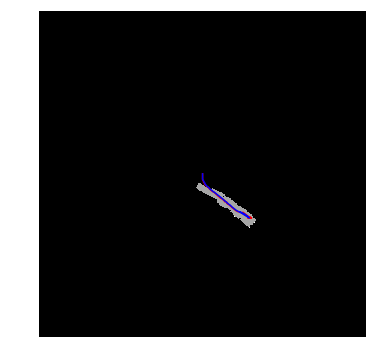

figure 103 is saved to results/22_10_200_15.0_-15.0_0.3_103.png


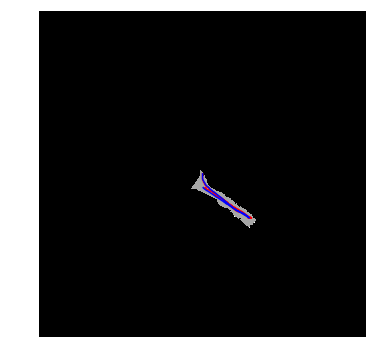

figure 155 is saved to results/22_10_200_15.0_-15.0_0.3_155.png


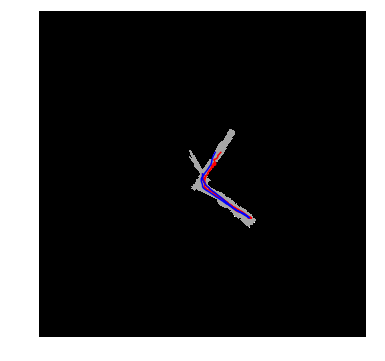

figure 207 is saved to results/22_10_200_15.0_-15.0_0.3_207.png


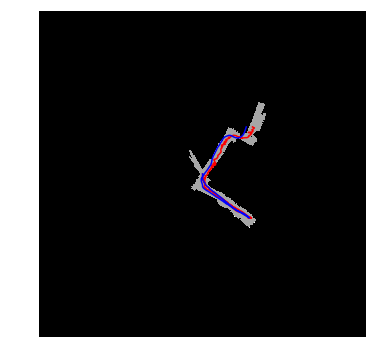

figure 259 is saved to results/22_10_200_15.0_-15.0_0.3_259.png


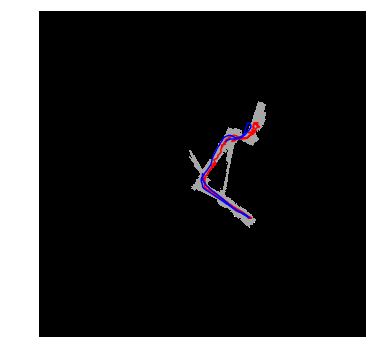

figure 311 is saved to results/22_10_200_15.0_-15.0_0.3_311.png


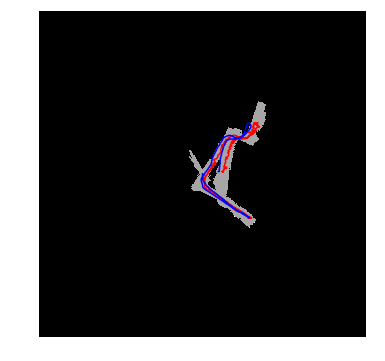

figure 363 is saved to results/22_10_200_15.0_-15.0_0.3_363.png


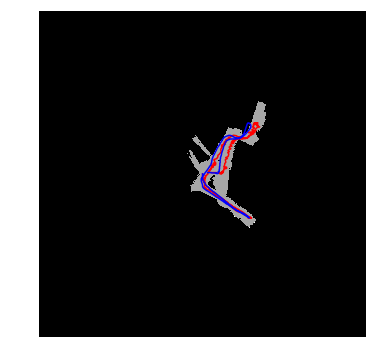

figure 415 is saved to results/22_10_200_15.0_-15.0_0.3_415.png


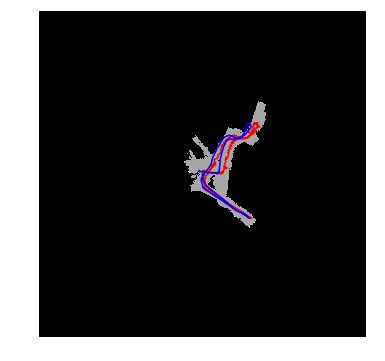

figure 467 is saved to results/22_10_200_15.0_-15.0_0.3_467.png


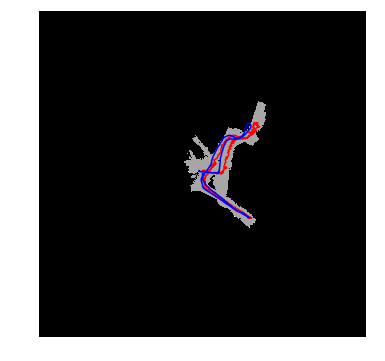

figure 475 is saved to results/22_10_200_15.0_-15.0_0.3_475.png
CPU times: user 34min 24s, sys: 7min 35s, total: 41min 59s
Wall time: 42min 6s


In [28]:
%%time

RESULT_DIR = 'results/'
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)
    
n = len(xs)
lidar_angles = lidars[0]['angle']
lidar_starting_angle = -135 / 180 * np.pi
noise = np.array([0.3, 0.3, 0.1 * np.pi / 180]) # x, y, theta
log_prob = np.log(0.9/0.1)
particles = 200
iters_start_map = n // 20
draw_thresh = n // 9
ocpy_thresh = 150 / sample_rate
empty_thresh = -ocpy_thresh


slam = Slam(n, lidar_angles, lidar_starting_angle, noise, log_prob, ocpy_thresh, empty_thresh, res=0.1, grid_size=1000, iters_start_map=iters_start_map, n_particles=particles)
for i in range(n):
    slam.update(xs[i], ys[i], thetas[i], lidars[i]['scan'], tilted[i])
    if (i + 1) % draw_thresh == 0 or i == n - 1:
        slam_map, particle, odometry = slam.getResults()
        plt.figure(figsize=[6, 6])
        plt.axis('off')
        plt.imshow(slam_map, cmap='gray', vmin=0, vmax=1)
        plt.plot(particle[1:i, 1], odometry[1:i, 0], 'r-')
        plt.plot(odometry[1:i, 1], odometry[1:i, 0], 'b-')
        path = f'{RESULT_DIR}{TEST_NO}_{sample_rate}_{particles}_{ocpy_thresh}_{empty_thresh}_{noise[0]}_{i}.png'
        plt.savefig(path)
        plt.show()
        plt.close()
        print(f"figure {i} is saved to", path)
        